In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, Flatten

In [3]:
df = pd.read_csv('C:\\Users\\HP\\Downloads\\Spam\\SMSSpamCollection', sep ='\t',names=["label", "message"])
df[:3]


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
duplicatedRow = df[df.duplicated()]
print(duplicatedRow[:15])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls
339   ham                             Sorry, I'll call later
357  spam  Congratulations ur awarded 500 of CD vouchers ...
444   ham                             Sorry, I'll call later
533   ham                  Gudnite....tc...practice going on
655   ham                       Did u got that persons story
658   ham               You will be in the place of that man
702   ham                             Sorry, I'll call later
768   ham                             Sorry, I'll call later
769   ham  I cant pick the phone right now. Pls send a me...
775   ham                         Just sleeping..and surfing


In [6]:
df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [7]:
df['label'].isnull().sum()

0

In [8]:
df['message'].isnull().sum()

0

In [12]:
# Get all the ham and spam sms
ham_msg = df[df.label =='ham']
spam_msg = df[df.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

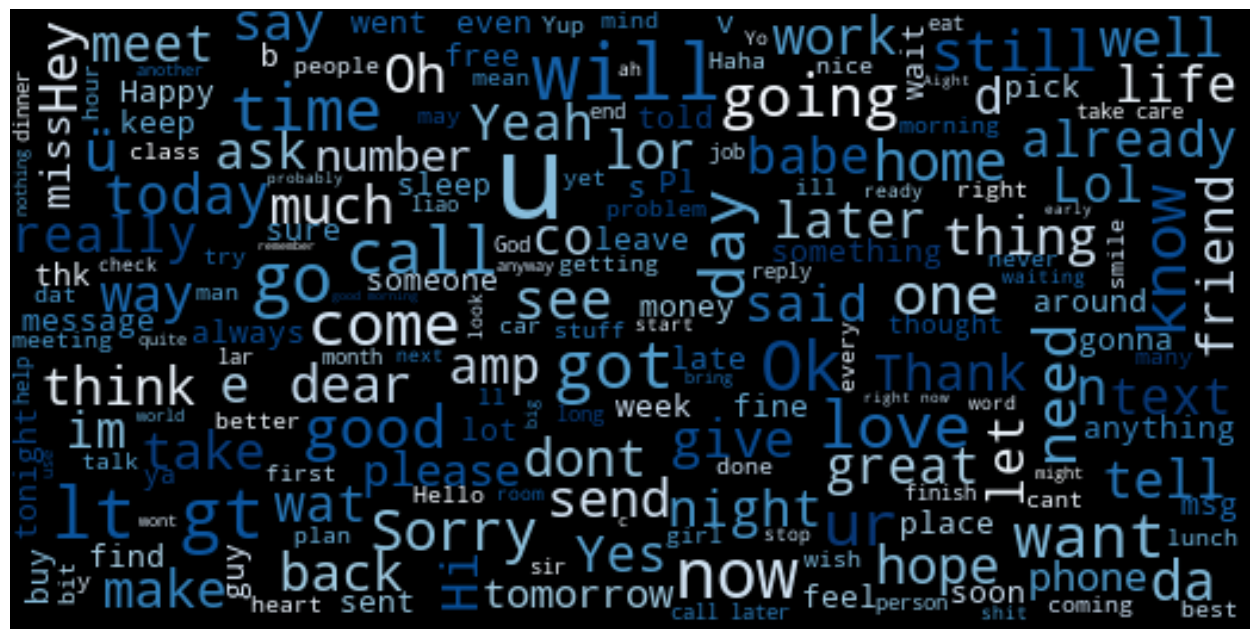

In [15]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

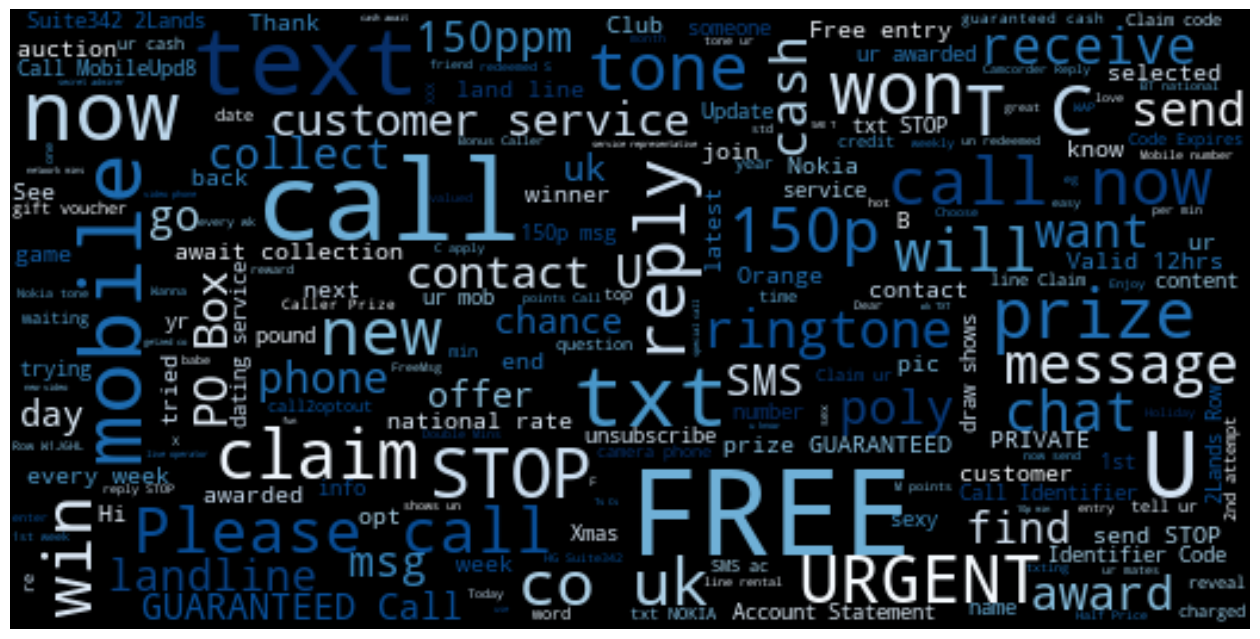

In [17]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

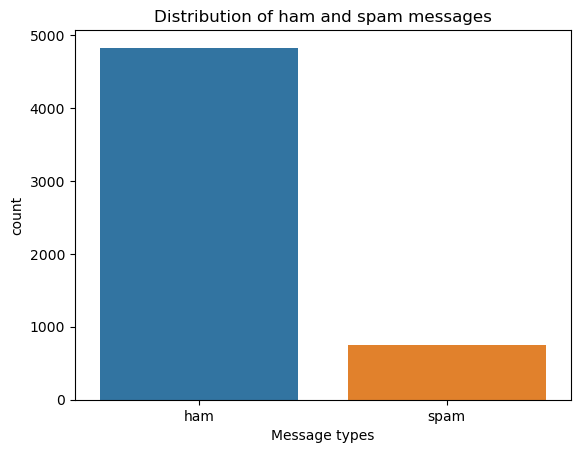

In [18]:
#To find the count of spam and ham messages
sns.countplot(x='label',data=df)
plt.title('Distribution of ham and spam messages')
plt.xlabel('Message types')
plt.show()

In [20]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape,spam_msg_df.shape)

(747, 2) (747, 2)


C:\Users\HP\AppData\Local\Temp\ipykernel_18568\1805022981.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)


<Axes: title={'center': 'Distribution of ham and spam sms messages (after downsampling)'}, xlabel='label', ylabel='count'>

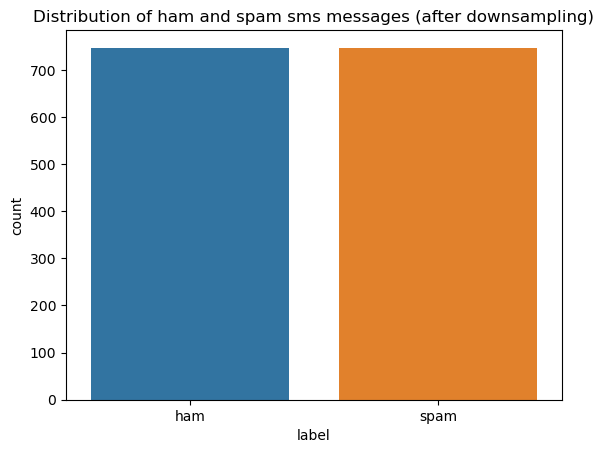

In [98]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.title('Distribution of ham and spam sms messages (after downsampling)')
plt.xlabel('Message types')
sns.countplot(x='label',data=msg_df)

In [32]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean(numeric_only=True)
labels

,text_length
label,
ham,73.238286
spam,138.670683


In [35]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [37]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [39]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [40]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [42]:
# check how many words 
tot_words = len(word_index)
print('%s unique tokens in training data. ' % tot_words)

4169 unique tokens in training data. 


In [44]:
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [45]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [46]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [47]:
# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [48]:
print(training_padded[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [50]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [52]:
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

In [55]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [56]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6809 - accuracy: 0.6795 - val_loss: 0.6682 - val_accuracy: 0.7960 - 1s/epoch - 29ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6481 - accuracy: 0.8268 - val_loss: 0.6286 - val_accuracy: 0.8395 - 75ms/epoch - 2ms/step
Epoch 3/30
38/38 - 0s - loss: 0.5925 - accuracy: 0.8678 - val_loss: 0.5628 - val_accuracy: 0.8462 - 83ms/epoch - 2ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5170 - accuracy: 0.8795 - val_loss: 0.4871 - val_accuracy: 0.8495 - 77ms/epoch - 2ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4309 - accuracy: 0.8879 - val_loss: 0.4129 - val_accuracy: 0.8595 - 165ms/epoch - 4ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3644 - accuracy: 0.8946 - val_loss: 0.3557 - val_accuracy: 0.8763 - 92ms/epoch - 2ms/step
Epoch 7/30
38/38 - 0s - loss: 0.3040 - accuracy: 0.9071 - val_loss: 0.3088 - val_accuracy: 0.8863 - 83ms/epoch - 2ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2593 - accuracy: 0.9172 - val_loss: 0.2733 - val_accuracy: 0.8963 - 77ms/epoch - 2ms/step
Epoch 9/30
38/38 - 0s - 

In [58]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 1ms/step - loss: 0.1180 - accuracy: 0.9532


[0.11795586347579956, 0.953177273273468]

In [62]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

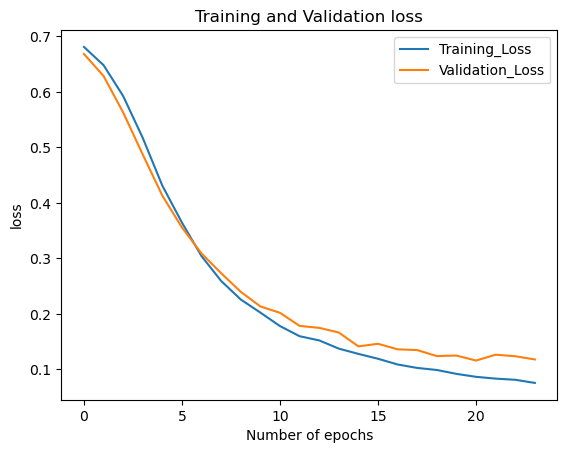

In [63]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

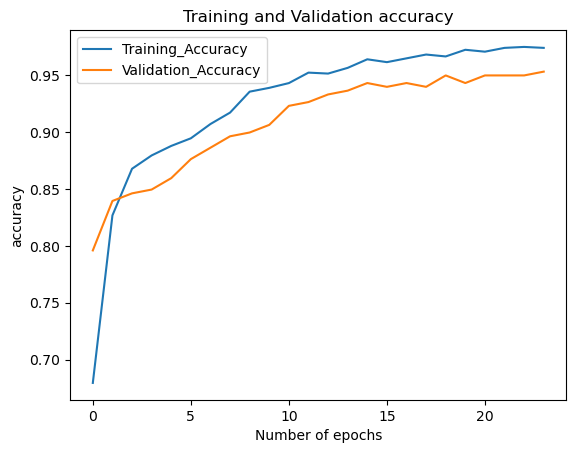

In [64]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [65]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

In [67]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

In [69]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [71]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)

print(training_padded.shape)
print(train_labels.shape)

y_train = np.asarray(training_padded).astype('float32').reshape((-1,1))
y_test = np.asarray(train_labels).astype('float32').reshape((-1,1))
print(y_train.shape)
print(y_test.shape)

model1.add(Flatten())
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

(1195, 50)
(1195,)
(59750, 1)
(1195, 1)
Epoch 1/30
38/38 - 1s - loss: 0.1322 - accuracy: 0.4251 - val_loss: 0.2007 - val_accuracy: 0.4314 - 930ms/epoch - 24ms/step
Epoch 2/30
38/38 - 1s - loss: 0.1271 - accuracy: 0.4226 - val_loss: 0.3261 - val_accuracy: 0.3880 - 898ms/epoch - 24ms/step
Epoch 3/30
38/38 - 1s - loss: 0.1230 - accuracy: 0.4268 - val_loss: 0.2418 - val_accuracy: 0.4314 - 883ms/epoch - 23ms/step


In [74]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

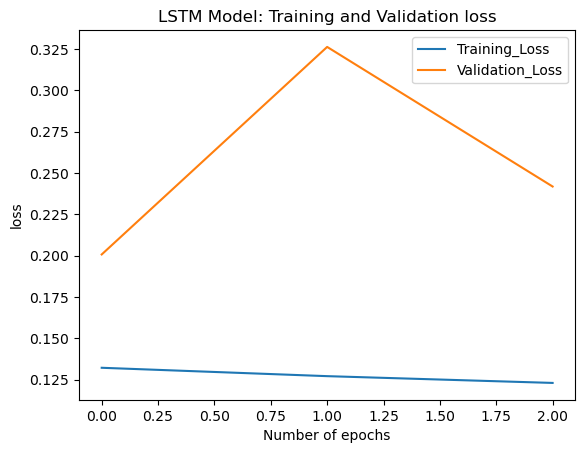

In [75]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

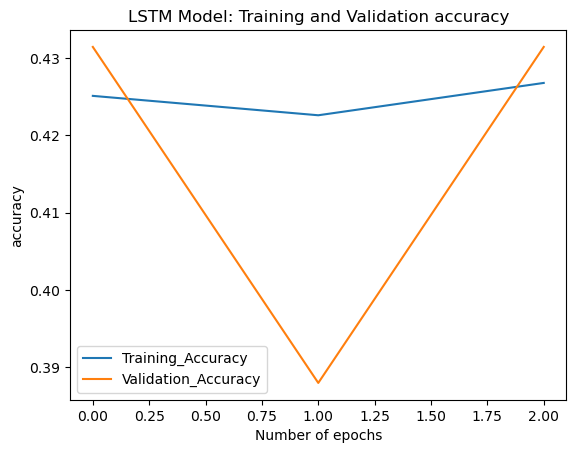

In [76]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [78]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

In [79]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [80]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
model2.add(Flatten())
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 4s - loss: 0.6711 - accuracy: 0.1808 - val_loss: 0.6154 - val_accuracy: 0.2408 - 4s/epoch - 116ms/step
Epoch 2/30
38/38 - 1s - loss: 0.4405 - accuracy: 0.1950 - val_loss: 0.3294 - val_accuracy: 0.1806 - 576ms/epoch - 15ms/step
Epoch 3/30
38/38 - 1s - loss: 0.2564 - accuracy: 0.2209 - val_loss: 0.2339 - val_accuracy: 0.3110 - 566ms/epoch - 15ms/step
Epoch 4/30
38/38 - 1s - loss: 0.1993 - accuracy: 0.1816 - val_loss: 0.2278 - val_accuracy: 0.1171 - 583ms/epoch - 15ms/step
Epoch 5/30
38/38 - 1s - loss: 0.1574 - accuracy: 0.2075 - val_loss: 0.1650 - val_accuracy: 0.2876 - 582ms/epoch - 15ms/step
Epoch 6/30
38/38 - 1s - loss: 0.1287 - accuracy: 0.2201 - val_loss: 0.1824 - val_accuracy: 0.2007 - 566ms/epoch - 15ms/step
Epoch 7/30
38/38 - 1s - loss: 0.1135 - accuracy: 0.1155 - val_loss: 0.1313 - val_accuracy: 0.1940 - 580ms/epoch - 15ms/step
Epoch 8/30
38/38 - 1s - loss: 0.1078 - accuracy: 0.1908 - val_loss: 0.1415 - val_accuracy: 0.2809 - 877ms/epoch - 23ms/step
Epoch 9/30

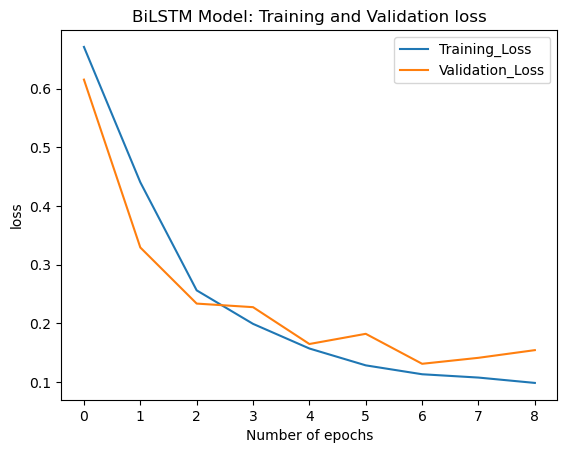

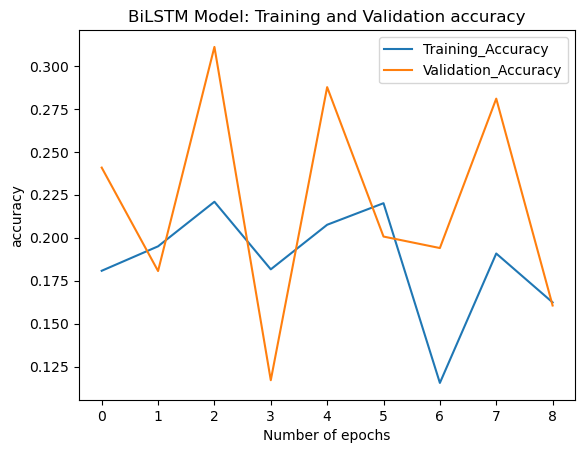

In [82]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [83]:
#comparing 3 different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 1ms/step - loss: 0.1180 - accuracy: 0.9532
Dense architecture loss and accuracy: [0.11795586347579956, 0.953177273273468] 
10/10 [==============================] - 0s 5ms/step - loss: 0.2418 - accuracy: 0.4314
LSTM architecture loss and accuracy: [0.24175989627838135, 0.4314381182193756] 
10/10 [==============================] - 0s 5ms/step - loss: 0.1546 - accuracy: 0.1605
Bi-LSTM architecture loss and accuracy: [0.15458634495735168, 0.16053511202335358] 


In [85]:
# display long string 
pd.options.display.max_colwidth=100
df[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [86]:
#predicting spam on raw data from dataset
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."]

In [87]:
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)

1/1 [==============================] - 1s 759ms/step


array([[0.02086543]], dtype=float32)

In [88]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
               "Ok lar... Joking wif u oni...",
               "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [89]:
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)

1/1 [==============================] - 0s 26ms/step


array([[0.02086543],
       [0.01024498],
       [0.99935174]], dtype=float32)

In [90]:
#predicting spam on any message
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
               "What's up?", "I am in college call me.", "You are rewarded 10000 prize"]
predict_spam(predict_msg)

1/1 [==============================] - 0s 25ms/step


array([[0.86802757],
       [0.04775584],
       [0.02295598],
       [0.02751176],
       [0.12543012]], dtype=float32)

In [93]:
#predicting spam on any message
predict_msg = ["Hi Ansfrid"]
predict_spam(predict_msg)

1/1 [==============================] - 0s 10ms/step


array([[0.02908596]], dtype=float32)

In [94]:
#predicting spam on any message
predict_msg = ["Entertainment at just Rs 100! Get Sony liv TV+Mobile Subricption with 10 GB Data for 30 Days. Subscribe now https://bit.ly/sonyliv_CB"]
predict_spam(predict_msg)

1/1 [==============================] - 1s 989ms/step


array([[0.93995017]], dtype=float32)